# Exercise 2

Name: Adam Dzadon

Student number: 2407741

## Libraries

First, let us import and install all the libraries we are going to use for the exercise.

We are going to use:

*   [PyTorch](https://pytorch.org/) for neural network building blocks and training resources
*   [Pandas](https://pandas.pydata.org/docs/) for pretty table printing
*   [NumPy](https://numpy.org/doc/) for fast numerical computations
*   [Matplotlib](https://matplotlib.org/stable/index.html) for data visualization
*   [tqdm](https://tqdm.github.io/) for progress bar during the training


In [12]:
!pip install torchmetrics

In [13]:
import torch
import torchvision
import torchmetrics
from torch.utils.data import DataLoader
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

## NN architecture

Next, we are going to take our CNN from EX1:

In [14]:
class CNN(nn.Module):
    def __init__(self,
                 in_size: tuple[int, int],
                 in_dim: int,
                 out_classes: int,
                 activation: nn.Module,
                 output_activation) -> None:
        """
        Parameters:
            - in_size          : spatial dimensions of input images
            - in_dim           : number of channels of input images
            - out_classes      : target number of classes
            - activation       : node function used in hidden layers
            - output_actiation : final activation
        """
        super().__init__()

        conv_w = in_size[0] // 8
        conv_h = in_size[1] // 8

        self.network = nn.Sequential(
            nn.Conv2d(in_dim, 32, 3, padding="same"),
            activation(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding="same"),
            activation(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding="same"),
            activation(),
            nn.MaxPool2d(2),

            nn.Flatten(),

            nn.Linear(128 * conv_w * conv_h, 64),
            activation(),
            nn.Linear(64, out_classes)
        )

        self.output_activation = output_activation

    def forward(self, x: torch.tensor) -> torch.tensor:
        return self.output_activation(self.network(x))

## Data preparation

In this exercise, we work only with CIFAR 10 dataset.

In [15]:
def show_images(ims: list[torch.tensor], labels: list[int | str], preds: list[int | str]=None, mnist: bool=True) -> None:
    assert len(ims) == len(labels)

    rows, cols = len(ims) // 3, 3
    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

    for i in range(len(ims)):
        row, col = divmod(i, cols)

        if mnist:
            image_np = (ims[i].permute(1, 2, 0) * 255).to(torch.uint8).numpy()
            axes[row, col].imshow(image_np, cmap='gray')
        else:
            image_np = (((ims[i].permute(1, 2, 0) + 1) / 2) * 255).to(torch.uint8).numpy()
            axes[row, col].imshow(image_np)

        axes[row, col].axis('off')

        desc = "Target: " + str(labels[i]) + "\n" + "Prediction: " + str(preds[i]) if preds is not None else labels[i]
        axes[row, col].set_title(desc, fontsize=12)

### CIFAR10

We prepare CIFAR10 dataset:

In [16]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
  ]
)

In [17]:
CIFAR10_train = torchvision.datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=transforms,
)

CIFAR10_test = torchvision.datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=transforms,
)

Files already downloaded and verified
Files already downloaded and verified


We also add a translation for the target classes (from numbers encoding them to names of the classes):

In [18]:
CIFAR10_translate = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

Let us observe some characteristics of our data:

In [19]:
print("Train size:", len(CIFAR10_train))
print("Test size:", len(CIFAR10_test))

Train size: 50000
Test size: 10000


We observe that this time, we have a bit less training data.

In [20]:
im = CIFAR10_train[0][0]
print("Dimensions:", im.shape)
CIFAR10_dims = im.shape[1], im.shape[2]
print("Pixel boundaries:", torch.min(im), torch.max(im))

Dimensions: torch.Size([3, 32, 32])
Pixel boundaries: tensor(-1.) tensor(1.)


We observe that the images are RGB (3 color channels) and are a bit larger - 32x32. Again, they are rescaled into [-1, 1] interval.

Finally, let us show some images from the dataset:

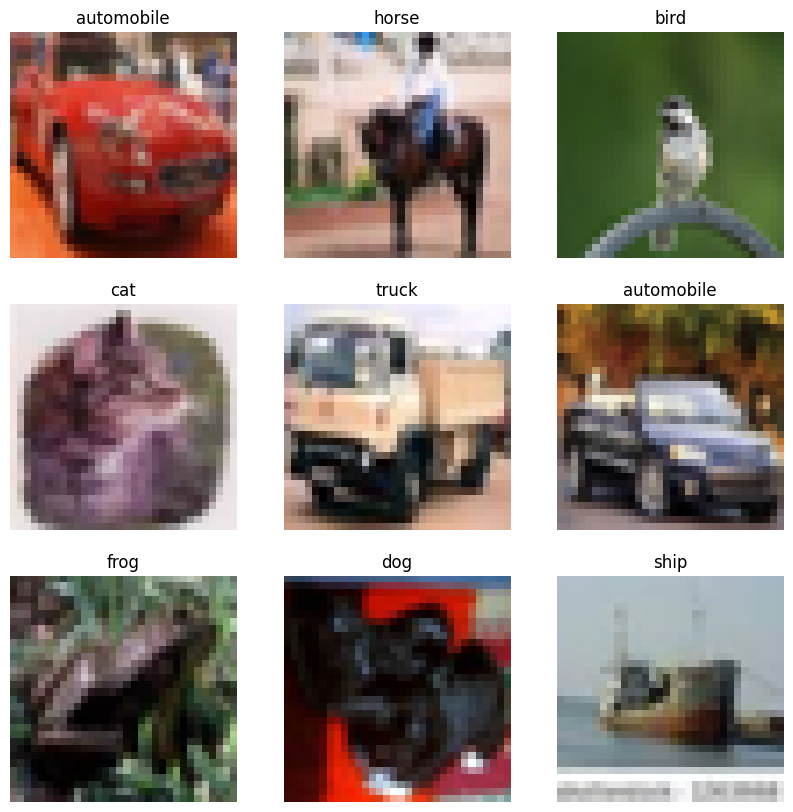

In [21]:
indices = [5, 11, 54, 174, 269, 354, 4123, 5698, 9951]
show_images([CIFAR10_train[i][0] for i in indices], [CIFAR10_translate[CIFAR10_train[i][1]] for i in indices], mnist=False)

## Training

We define the training procedure together with validation after each epoch:

In [ ]:
def train(train_data: DataLoader,
          val_data: DataLoader,
          model: nn.Module,
          loss_fn: nn.Module,
          optimizer: torch.optim.Optimizer,
          epochs: int) -> tuple[
              list[float], list[float], list[float], list[float]
              ]:
    """
    Parameters:
        - train_data: DataLoader containing training data
        - val_data  : DataLoader containing validation (test) data
        - model     : CNN to be trained
        - loss_fn   : Loss function used
        - optimizer : Object performing weight optimization
        - epochs    : Number of epochs
    """

    # --- Initialize accuracy computing unit
    acc = torchmetrics.classification.Accuracy(task="multiclass", num_classes=10)
    # ---

    # --- We are going to measure loss and accuracy on train and validation set for each epoch
    train_n_batches = len(train_data)
    val_n_batches = len(val_data)
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []
    # ---

    progress_bar = tqdm(range(epochs), desc=f"Epochs")
    for epoch in progress_bar:

        # --- Training
        epoch_loss = 0
        epoch_acc = 0

        for X_batch, Y_batch in train_data:
            optimizer.zero_grad() # zero gradients
            output = model(X_batch) # calculate model prediction
            l = loss_fn(output, Y_batch) # calculate loss
            l.backward() # calculate gradient
            optimizer.step() # update weights

            epoch_loss += l.item()
            epoch_acc += acc(output, Y_batch).item()

        train_loss.append(epoch_loss / train_n_batches) # epoch loss as an average for all batches
        train_acc.append(epoch_acc / train_n_batches) # epoch accuracy as an average for all batches
        # ---

        # --- Testing
        epoch_loss = 0
        epoch_acc = 0

        with torch.no_grad():   # no need of gradient for validation
            for X_batch, Y_batch in val_data:

                pred = model(X_batch)

                epoch_loss += loss_fn(pred, Y_batch).item()
                epoch_acc += acc(pred, Y_batch).item()

            val_loss.append(epoch_loss / val_n_batches)
            val_acc.append(epoch_acc / val_n_batches)
            print("Epoch accuracy: ", epoch_acc / val_n_batches)

        print()
        # ---

    return train_loss, val_loss, train_acc, val_acc

## LR and momentum tuning

We are going to tune LR and momentum hyper-parameters for SGD optimizer. We are going to do so by creating a pool of possible values for both of these, and train a model for each pair of possible combinations (grid search). Finally, we will try to find best performing model.


Let us define the above-mentioned pools of possible values for both hyper-parameters:

In [23]:
lrs = [0.001, 0.01, 0.1]
momenta = [0, 0.5, 0.9]

First, we set the fixed training hyper-parameters:

In [24]:
batch_size = 64
loss = nn.CrossEntropyLoss()
epochs = 15
hidden_act = nn.ReLU
optimizer = torch.optim.SGD

Notice that we fixed the hidden units activation to ReLU due to good performance in EX1.

Then, we create DataLoaders for CIFAR10 dataset:

In [25]:
CIFAR10_train_dataloader = DataLoader(CIFAR10_train, batch_size=batch_size, num_workers=16)
CIFAR10_test_dataloader = DataLoader(CIFAR10_test, batch_size=batch_size, num_workers=8)

And finally, train the models:

In [ ]:
CIFAR10_train_losses = []
CIFAR10_val_losses = []
CIFAR10_train_accs = []
CIFAR10_val_accs = []

CIFAR10_models = []
all_pairs = []

for lr in lrs:
    for momentum in momenta:

        all_pairs.append( (lr, momentum) )

        model = CNN(CIFAR10_dims, 3, 10, hidden_act, nn.Softmax(dim=1))
        tl, vl, ta, va = train(CIFAR10_train_dataloader, CIFAR10_test_dataloader, model, loss, optimizer(model.parameters(), lr=lr, momentum=momentum), epochs)

        CIFAR10_train_losses.append(tl)
        CIFAR10_val_losses.append(vl)
        CIFAR10_train_accs.append(ta)
        CIFAR10_val_accs.append(va)

        CIFAR10_models.append(model)

Finally, we are going to evaluate the trained models. We consider training and validation loss and accuracy.

First, let us take (and modify) some functions for the evaluation from EX1:

In [41]:
def metrics_by_hparams( train_loss: list[ list[float] ],
                        val_loss: list[ list[float] ],
                        train_acc: list[ list[float] ],
                        val_acc: list[ list[float] ]) -> pd.DataFrame:
    """
    Creates a table containing train and validation loss and accuracy for all activations
    """
    metrics =pd.DataFrame(
        {
            "Train loss": [l[-1] for l in train_loss],
            "Validation loss": [l[-1] for l in val_loss],
            "Train accuracy": [l[-1] for l in train_acc],
            "Validation accuracy": [l[-1] for l in val_acc]
        }
    )
    return metrics

In [47]:
def plot_by_hparams(train_vals: list[list[float]], val_vals: list[list[float]], label: str, texts: list[str]) -> None:
    """
    Plots given train / validation values by epoch
    """
    epochs = np.array( range( len(train_vals[0]) ) )

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.title("Train")
    for i in range( len(train_vals) ):
        label_text = texts[i]
        plt.plot(epochs, train_vals[i], label=label_text)
    plt.xlabel("Epoch")
    plt.ylabel(label)

    plt.subplot(1, 2, 2)
    plt.title("Validation")
    for i in range( len(val_vals) ):
        label_text = texts[i]
        plt.plot(epochs, val_vals[i], label=label_text)
    plt.xlabel("Epoch")
    plt.ylabel(label)

    plt.tight_layout()
    plt.legend()

In [29]:
def per_class_accuracy(model: nn.Module, data: DataLoader, n_classes: int) -> None:
    """
    Computes per-class accuracy of model on data (same as multiclass recall)
    """
    correct = [0 for _ in range(n_classes)]
    total = [0 for _ in range(n_classes)]

    with torch.no_grad():
        for X_batch, Y_batch in data:

            preds = model(X_batch)
            _, preds = torch.max(preds, 1)

            for target_class in range(n_classes):

                target_indices = Y_batch == target_class
                X = X_batch[target_indices]
                Y = Y_batch[target_indices]
                target_preds = preds[target_indices]

                correct[target_class] += (target_preds == Y).sum().item()
                total[target_class] += target_indices.sum().item()

    return [ correct[i] / total[i] for i in range(n_classes)]

We start by showing the last values of metrics for each parameter combination:

In [42]:
df = metrics_by_hparams(CIFAR10_train_losses, CIFAR10_val_losses, CIFAR10_train_accs, CIFAR10_val_accs)
df.index = all_pairs
df

,Train loss,Validation loss,Train accuracy,Validation accuracy
"(0.001, 0)",2.301945,2.301898,0.152534,0.156250
"(0.001, 0.5)",2.298396,2.297762,0.123801,0.130573
"(0.001, 0.9)",2.135416,2.118030,0.318254,0.338674
"(0.01, 0)",2.117021,2.107564,0.340433,0.349124
"(0.01, 0.5)",1.996166,1.995133,0.465293,0.464371
"(0.01, 0.9)",1.741504,1.790758,0.721607,0.669188
"(0.1, 0)",1.750039,1.824867,0.712276,0.634156
"(0.1, 0.5)",1.765150,1.790101,0.694633,0.669885
"(0.1, 0.9)",2.361007,2.361330,0.100144,0.099821


There are several observations to be made. First, we see that SGD with small LR values is struggling to learn, although, higher momentum values help. Also, too high LR and momentum are not ideal as well.

Next, we show the evolution of loss and accuracy for both train and validation datasets by epoch:

In [48]:
texts = [ f"lr={all_pairs[i][0]} momentum={all_pairs[i][1]}" for i in range(len(all_pairs)) ]

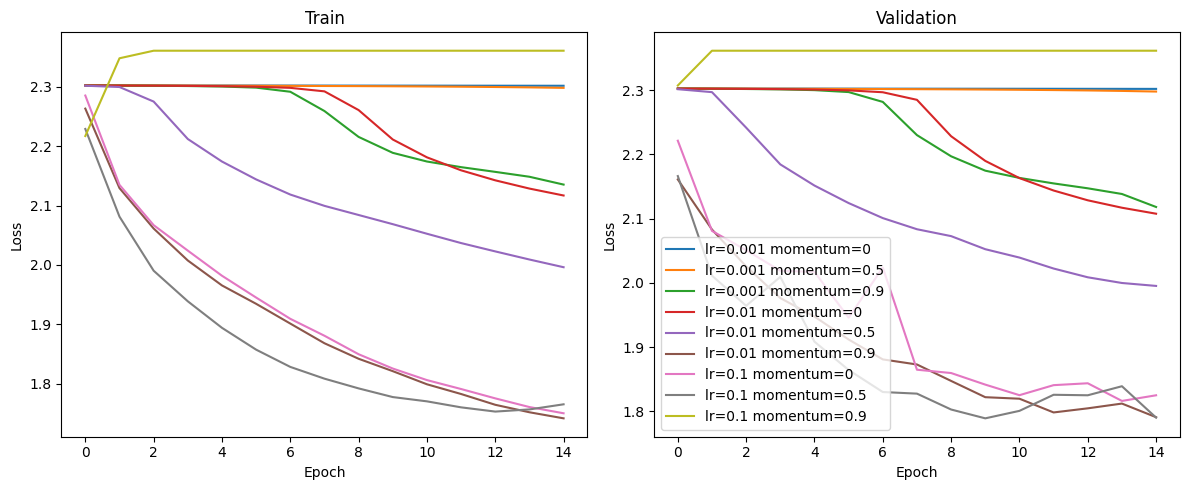

In [50]:
plot_by_hparams(CIFAR10_train_losses, CIFAR10_val_losses, "Loss", texts)

Notice that for too small LR, the loss is barely changing. Moreover, we observe that for too high LR and momentum, the loss is even increasing. This indicates that with high LR and momentum together, we make a really huge steps over the loss landscape, thus, overshooting the desired optima.

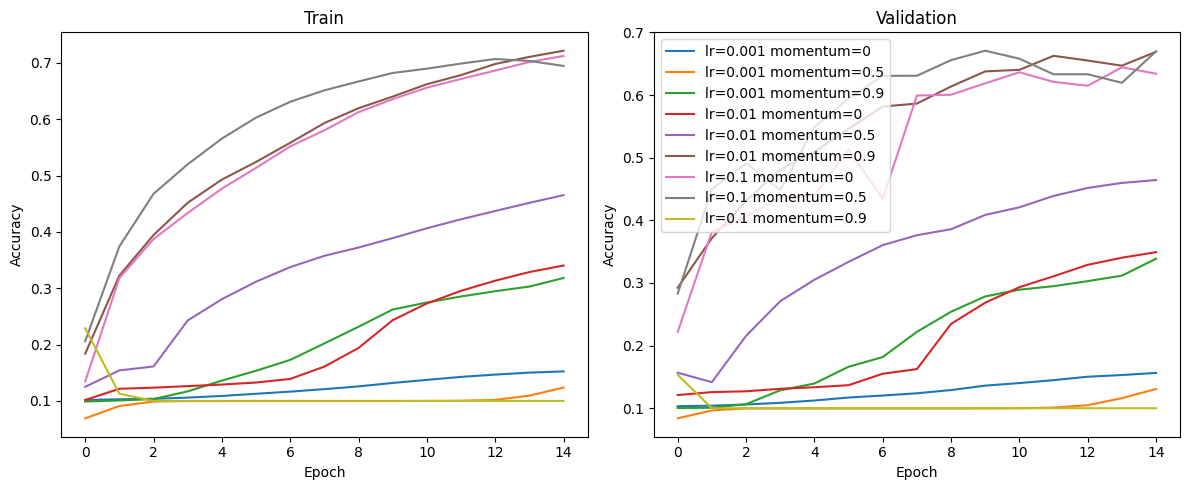

In [51]:
plot_by_hparams(CIFAR10_train_accs, CIFAR10_val_accs, "Accuracy", texts)

From the accuracy plots, we observe that the best performing models use LR of either 0.01 or 0.1, which is typical for SGD. With higher LR, the smaller momentum is more suitable, and for smaller LR, the higher momentum is usually applied. This helps to avoid saddle points and local optima during the training.

Finally, let us demonstrate the per-class accuracy of each model:

In [36]:
data = {}
for i in range( len(all_pairs) ):
    data[ f"lr={all_pairs[i][0]} mom={all_pairs[i][1]}" ] = per_class_accuracy(CIFAR10_models[i], CIFAR10_test_dataloader, 10)

df = pd.DataFrame(data)
df.index = CIFAR10_translate
df

,lr=0.001 mom=0,lr=0.001 mom=0.5,lr=0.001 mom=0.9,lr=0.01 mom=0,lr=0.01 mom=0.5,lr=0.01 mom=0.9,lr=0.1 mom=0,lr=0.1 mom=0.5,lr=0.1 mom=0.9
airplane,0.000,0.209,0.370,0.437,0.524,0.759,0.716,0.726,0.0
automobile,0.803,0.000,0.450,0.490,0.463,0.814,0.785,0.828,1.0
bird,0.000,0.000,0.001,0.111,0.184,0.389,0.604,0.555,0.0
cat,0.000,0.000,0.211,0.000,0.535,0.489,0.516,0.642,0.0
deer,0.764,0.001,0.196,0.184,0.245,0.530,0.640,0.528,0.0
dog,0.000,0.000,0.321,0.358,0.267,0.529,0.386,0.440,0.0
frog,0.000,0.000,0.584,0.532,0.603,0.902,0.512,0.670,0.0
horse,0.000,0.000,0.284,0.393,0.581,0.697,0.859,0.809,0.0
ship,0.000,0.162,0.591,0.490,0.588,0.804,0.798,0.776,0.0
truck,0.000,0.940,0.377,0.492,0.655,0.778,0.523,0.730,0.0


Again, we see that for too small LR and momentum values, the models are absolutely unable to learn. Same holds for too big LR and momentum values. For the relatively optimal values we found, we see that the models struggle mostly with the animal classification.

## Optimizer comparison

As our next task, we try to find the best performing optimizing algorithm. Namely, we will compare the following algorithms:

*   SGD
*   RMSprop
*   AdaGrad
*   Adam



In [43]:
optims = [ torch.optim.SGD, torch.optim.RMSprop, torch.optim.Adagrad, torch.optim.Adam ]
optim_labels = ["SGD", "RMSprop", "AdaGrad", "Adam"]

We are also going to fix the usual values for lr and momentum:

In [38]:
lr = 0.001
momentum = 0.5

The rest of hyper-parameters stays the same. Now, we are ready to train the models:

In [ ]:
optimizer_train_losses = []
optimizer_val_losses = []
optimizer_train_accs = []
optimizer_val_accs = []

optimizer_models = []

for i in range(len(optims)):
    model = CNN(CIFAR10_dims, 3, 10, hidden_act, nn.Softmax(dim=1))
    opt = optims[i](model.parameters(), lr=lr, momentum=momentum) if i <= 1 else optims[i](model.parameters(), lr=lr)
    tl, vl, ta, va = train(CIFAR10_train_dataloader, CIFAR10_test_dataloader, model, loss, opt, epochs)

    optimizer_train_losses.append(tl)
    optimizer_val_losses.append(vl)
    optimizer_train_accs.append(ta)
    optimizer_val_accs.append(va)

    optimizer_models.append(model)

Next, we are going to evaluate which optimizer performed best with the fixed LR and momentum values. We proceed in the same manner as for the LR and momentum tuning.

First, the obtained metrics for each optimizer:

In [45]:
df = metrics_by_hparams(optimizer_train_losses, optimizer_val_losses, optimizer_train_accs, optimizer_val_accs)
df.index = optim_labels
df

,Train loss,Validation loss,Train accuracy,Validation accuracy
SGD,2.301403,2.301300,0.143043,0.141819
RMSprop,1.812429,1.802606,0.648038,0.658141
AdaGrad,2.026371,2.021350,0.437000,0.441481
Adam,1.670791,1.755657,0.790561,0.704419


We observe that Adam and RMSprop outperform AdaGrad and SGD by a large margin.

Let us plot the obtained accuracies and loss values:

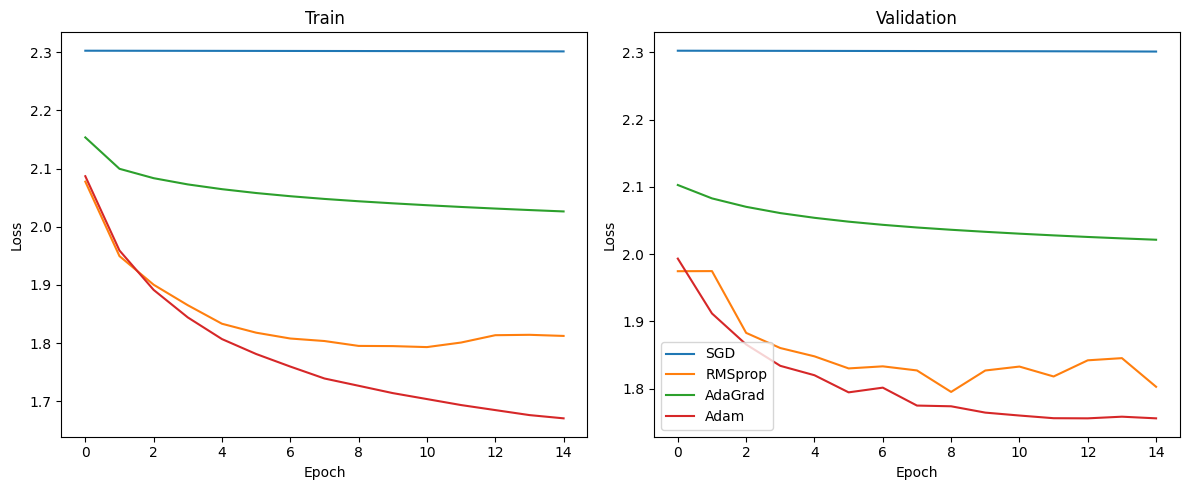

In [52]:
plot_by_hparams(optimizer_train_losses, optimizer_val_losses, "Loss", optim_labels)

We observe that for the selected LR and momentum values, the SGD is absolutely unable to train. This is not unexpected since in the previous task we found out that SGD needs higher value of LR (around 0.01) to work.

Next, we show the obtained accuracies:

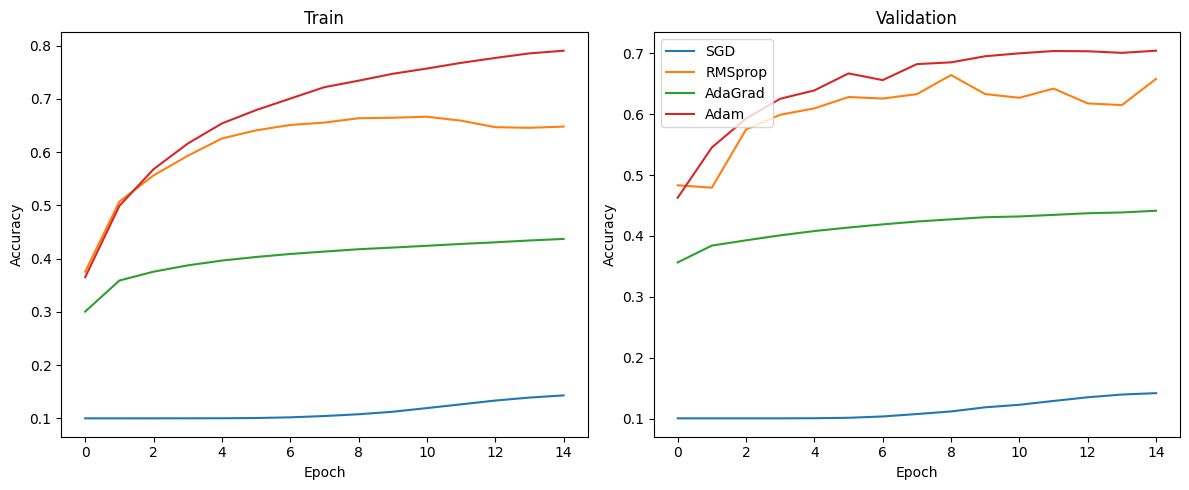

In [53]:
plot_by_hparams(optimizer_train_accs, optimizer_val_accs, "Accuracy", optim_labels)

We observe that Adam and RMSprop optimizers perform significantly better than the rest. We conclude that **Adam** performs the best out of the optimizers. However, we need to be mindful that it might strongly depend on selected values of other hyper-parameters (like LR and momentum) and also the problem we solve.

Finally, we reveal the per-class accuracies:

In [54]:
data = {}
for i in range( len(optim_labels) ):
    data[ optim_labels[i] ] = per_class_accuracy(optimizer_models[i], CIFAR10_test_dataloader, 10)

df = pd.DataFrame(data)
df.index = CIFAR10_translate
df

,SGD,RMSprop,AdaGrad,Adam
airplane,0.676,0.678,0.498,0.792
automobile,0.000,0.847,0.642,0.903
bird,0.000,0.554,0.169,0.565
cat,0.000,0.501,0.393,0.442
deer,0.000,0.543,0.278,0.698
dog,0.740,0.494,0.354,0.546
frog,0.000,0.785,0.588,0.809
horse,0.000,0.729,0.517,0.811
ship,0.000,0.833,0.487,0.708
truck,0.000,0.613,0.492,0.774


We observe that SGD did not manage to learn (it never predicted anything else beside dog and airplane). Regarding the performance of Adam, it is very similar to one obtained in EX1. Finally, we observe the similar struggles for all the optimizers, namely, to distinguish animals from each other. This might be fundamentally difficult task since all the models struggle to do that.